<a href="https://colab.research.google.com/github/Reichidad/Machine-Learning-2020-Spring-Class/blob/assignment09/assignment09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label classification using neural networks
## 20145822 김영현
___


## Training & Testing Code
___

In [0]:
import matplotlib.pyplot as plt
import numpy as np

file_data   = "/content/drive/My Drive/Colab Notebooks/data09/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
num_train = 6000
num_test = 4000
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# make a matrix each column of which represents an images in a vector form
#
list_image_train  = np.empty((size_row * size_col, num_train), dtype=float)
list_label_train  = np.empty(num_train, dtype=int)
list_image_test = np.empty((size_row * size_col, num_train), dtype=float)
list_label_test  = np.empty(num_test, dtype=int)

train_loss_list = []
train_accr_list = []
test_loss_list = []
test_accr_list = []

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    if count < num_train:
      list_label_train[count]       = label
      list_image_train[:, count]    = im_vector
    else:
      list_label_test[count - num_train] = label
      list_image_test[:, count - num_train] = im_vector
    count += 1

theta_u = np.random.randn(196, 785)
theta_v = np.random.randn(49, 197)
theta_w = np.random.randn(10,50)
alpha = 0.9

one_hot_label_train = np.zeros((10, num_train), dtype=float)
for i in range(num_train):
  one_hot_label_train[list_label_train[i],i] = 1
one_hot_label_test = np.zeros((10, num_test), dtype=float)
for i in range(num_test):
  one_hot_label_test[list_label_test[i],i] = 1
# fully connected calculation with bias(1)
def func_calc(theta_list, op_list):
  return np.matmul(theta_list, np.insert(op_list, 0, 1))


# sigmoid calculation
def sigmoid(val):
  return 1/(1+np.exp(-val))


# derivative of the sigmoid
def d_sigmoid(val):
  sig_now = sigmoid(val)
  return sig_now * (1 - sig_now)


# objective function
def ob_func(labels, results, num):
  sum = 0
  for i in range(num):
    for j in range(len(results)):
      sum += (-labels[j,i] * np.log(results[j][i])) - ((1 - labels[j,i]) * np.log(1 - results[j][i]))
  return sum/num


# main function for 1 iteration
def train_once():
  global theta_u, theta_v, theta_w
  result_set = np.empty((10, num_train))
  accr = 0
  theta_u_next = np.zeros((196, 785))
  theta_v_next = np.zeros((49, 197))
  theta_w_next = np.zeros((10, 50))
  
  for num in range(num_train):
    x = list_image_train[:, num]
    y = func_calc(theta_u, x)
    y_sigmoid = sigmoid(y)
    z= func_calc(theta_v, y_sigmoid)
    z_sigmoid = sigmoid(z)
    h = func_calc(theta_w, z_sigmoid)
    h_sigmoid = sigmoid(h)
    result_set[:, num] = h_sigmoid

    if np.argmax(h_sigmoid) == list_label_train[num]:
      accr += 1

    d_first = np.zeros(10)
    for i in range(10):
      d_first[i] = (1-one_hot_label_train[i,num])/(1-h_sigmoid[i]) - one_hot_label_train[i,num]/h_sigmoid[i]
      d_first[i] *= d_sigmoid(h[i])
    theta_w_next += np.matmul(d_first.reshape(10,1), np.insert(z_sigmoid, 0, 1).reshape(1,50))
    
    d_second = np.matmul(d_first, theta_w)
    for i in range(1,50):
      d_second[i] *= d_sigmoid(z[i-1])
    theta_v_next += np.matmul(d_second[1:].reshape(49, 1), np.insert(y_sigmoid, 0, 1).reshape(1, 197))

    d_third = np.matmul(d_second[1:50], theta_v)
    for i in range(1,197):
      d_third[i] *= d_sigmoid(y[i-1])
    theta_u_next += np.matmul(d_third[1:].reshape(196,1), np.insert(x, 0, 1).reshape(1, 785))

  train_loss = ob_func(one_hot_label_train, result_set, num_train)
  train_loss_list.append(train_loss)
  accr = accr * 100 / num_train
  train_accr_list.append(accr)

  test_result_set = np.empty((10, num_train))
  test_accr = 0
  for num in range(num_test):
      x = list_image_test[:, num]
      y = func_calc(theta_u, x)
      y_sigmoid = sigmoid(y)
      z= func_calc(theta_v, y_sigmoid)
      z_sigmoid = sigmoid(z)
      h = func_calc(theta_w, z_sigmoid)
      h_sigmoid = sigmoid(h)
      test_result_set[:, num] = h_sigmoid

      if np.argmax(h_sigmoid) == list_label_test[num]:
        test_accr += 1
  test_loss = ob_func(one_hot_label_test, test_result_set, num_test)
  test_loss_list.append(test_loss)
  test_accr = test_accr * 100 / num_test
  test_accr_list.append(test_accr)

  theta_u -= (alpha * theta_u_next/num_train)
  theta_v -= (alpha * theta_v_next/num_train)
  theta_w -= (alpha * theta_w_next/num_train)


iteration = 0
while iteration < 500:
  train_once()
  if iteration > 0:
    if abs(train_loss_list[iteration] - train_loss_list[iteration-1]) < 0.001:
      break
  iteration += 1
  if iteration == 400:
    alpha = 0.1



In [45]:
print("iteration finished with\n",
            "iteration :", iteration-1,"\n",
            "train_loss :", train_loss_list[-1],"\n",
            "train_accr :", train_accr_list[-1], "%\n",
            "test_loss :", test_loss_list[-1], "\n",
            "test_accr :", test_accr_list[-1], "%")

iteration finished with
 iteration : 343 
 train_loss : 0.6895884150794045 
 train_accr : 90.26666666666667 %
 test_loss : 0.9352388003011123 
 test_accr : 84.65 %


## Submission
___

### 1. Plot the loss curve
___

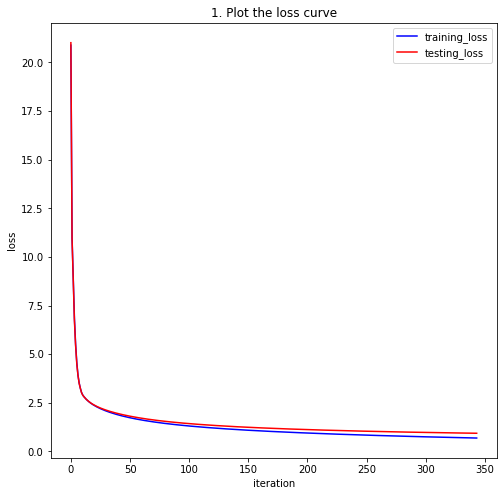

In [47]:
plt.figure(figsize=(8,8))
plt.title("1. Plot the loss curve")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot([i for i in range(iteration)], train_loss_list, label="training_loss", c='b')
plt.plot([i for i in range(iteration)], test_loss_list, label="testing_loss", c='r')
plt.legend()
plt.show()